# Temperature Profile Classification - 2 Class system - Full DataSet Load
GMM classification of Southern Ocean Argo float temperature profile data. This notebook uses a previously created model, PCA and sample data.<br><br>
### Dask import

In [1]:
#Dask server setup cell
'''
target_version='0.19.0'
!pip install xarray=={target_version} --upgrade #--upgrade

import logging
import subprocess
from dask.distributed import Client
from dask_gateway import Gateway
from distributed import WorkerPlugin

import dask
dask.config.set({"array.slicing.split_large_chunks": True})
 
class PipPlugin(WorkerPlugin):
    """
    Install packages on a worker as it starts up.
 
    Parameters
    ----------
    packages : List[str]
        A list of packages to install with pip on startup.
    """
    def __init__(self, packages):
        self.packages = packages
 
    def setup(self, worker):
        logger = logging.getLogger("distributed.worker")
        subprocess.call(['python', '-m', 'pip', 'install', '--upgrade'] + self.packages)
        logger.info("Installed %s", self.packages)
        
def check():
    import xarray
    return xarray.__version__
        
gateway = Gateway()
cluster = gateway.new_cluster(worker_memory=8)
cluster.scale(20)
client = Client(cluster)
client
 
plugin = PipPlugin([f'xarray=={target_version}'])
client.register_worker_plugin(plugin)
client.run(check)
'''
blank=1

In [2]:
#client

<br>

### Choices for data

In [3]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceId = 'UKESM1-0-LL'
dataInstitutionId = 'MOHC'
approvedIds = ["r2i1p1f2"] #insert start of approved member_ids

#File imports
maskName = "OceanMaskVolcello"
modelName = "GMM_UK_2Class_R1"

#Data definitions
startDate = '1980-01'
endDate = '2009-12'
timeRange = slice(startDate, endDate)
levSel = slice(0, 2000) #Selected levels to be investigated
maxLat = -30 #Selected latitude to be investigated
runIdSel = 0
maskEnable = False #Decides if training data mask is applied, or if full data set is classified

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [4]:
#Import cell
import calendar
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import matplotlib as mpl ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import config
from dask import delayed
from joblib import dump, load
from matplotlib.pyplot import cm
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing

config.set(**{'array.slicing.split_large_chunks': True})
print("Imports complete")

Imports complete


<br>

### Importing data sets
Importing the data for the models.

<b>Import sample data set and corresponding time/geo data</b>

In [5]:
#Importing UK ESM data cell

#Selecting data tables
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceId) & df.institution_id.eq(dataInstitutionId)]

memberArr = np.empty(shape=(0), dtype=bool)
for i in dfFilt["member_id"]:
    rowSel = i[:] in approvedIds #adapt i[:] to match size of approvedIds
    memberArr = np.append(memberArr, rowSel)

memberSer = pd.Series(memberArr, name='bools')
dfFilt = dfFilt[memberSer.values]

#Opening and counting number of tables
fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" "+dataSourceId+" data sets opened")
else:
    print("No UKESM data sets opened")
    
#Formatting dates into np.datetime64 format
for i in range(fileCount): 
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunId') #Combining data sets

dataRaw = fileSet.thetao
try: #Adjusting array names
    dataRaw = dataRaw.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

print("Data sets successfully merged and renamed into dataRaw. Data dimensions are "+str(dataRaw.sizes)+".")
#dataRaw

1 UKESM1-0-LL data sets opened
Data sets successfully merged and renamed into dataRaw. Data dimensions are Frozen({'RunId': 1, 'time': 1980, 'lev': 75, 'j': 330, 'i': 360}).


In [6]:
dfFilt

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
214481,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190708


In [7]:
#UK ESM raw processing cell
dfESMLev = dataRaw.sel(lev=levSel) #Selects level data down to 2k
dfESMLevT = dfESMLev.sel(time=timeRange)
dfESMLatLevT = dfESMLevT.where(dfESMLevT.lat < maxLat, drop=True) #Selection of latitude
dfESMLatLevT = dfESMLatLevT.squeeze()
#dfESMLatLevT = dfESMLatLevT.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLatLevT["time"][0].values
globalDateInc = dfESMLatLevT["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dfESMLatLevT["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("UKESM data loaded and stored in dfESMLatLevT. Data dimensions are "+str(dfESMLatLevT.sizes)+".")
#dfESMLatLevT #Uncomment to see data set

UKESM data loaded and stored in dfESMLatLevT. Data dimensions are Frozen({'time': 360, 'lev': 54, 'j': 139, 'i': 360}).


<br>
<b>Loading ocean Masks</b>

In [8]:
#Ocean mask import cell
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
maskFile = xr.open_dataset("OceanMaskUKESM1")
oceanMask2 = maskFile.to_array()
print("Mask Loaded and stored in oceanMask and oceanMask2 (volcello and UKESM).")

Mask Loaded and stored in oceanMask and oceanMask2 (volcello and UKESM).


<br>
<b>Unpacking ocean masks</b>

In [9]:
#Mask unpacking cell
geoRange = oceanMask #copying mask
geoRange = geoRange.rename({"variable":"cleanMe"}) #Dimension removal
geoRange = geoRange.sel(cleanMe = geoRange.cleanMe.values[0]) #Dimension removal
geoRange = geoRange.reset_coords("cleanMe", drop=True) #Dimension removal
geoRangeS = geoRange.stack(ij =("i", "j")) #Stacking
geoRangeFilt = geoRangeS.dropna("ij")
print("Ocean mask unpacked into geoRangeFilt.")

geoRange2 = oceanMask2 #copying mask
geoRange2S = geoRange2.stack(ij =("i", "j")) #Stacking
geoRangeFilt2 = geoRange2S.dropna("ij")
print("UKESM Ocean mask unpacked into geoRangeFilt2.")

Ocean mask unpacked into geoRangeFilt.
UKESM Ocean mask unpacked into geoRangeFilt2.


<br>
<b>Date Calculations</b>

In [10]:
#Date calculation cell
startDateNp = np.datetime64(startDate, 'M')
endDateNp = np.datetime64(endDate, 'M')
timeDiff = endDateNp - startDateNp
timeDiff = timeDiff.astype(int) + 1
print("Calculated date range.")

Calculated date range.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
<li>pickRand - Takes in data frame and returns sampled data frame with a randomly selected number of rows from the input data frame, controled by the second input variable to the function.
<li>storeMeta - Returns a np array containing the latitude and longitude data for an input xarray and associated ij.
<li>loadModel - loadeds and returns GMM model named in input.
<li>saveModel - saves input GMM model to provided name, if no name provided default is GMMGenerated.
</ul>

In [11]:
#Calculation functions cell
def pickRand(dataArray, sampleFactor):
    '''Returns a sample of the input array, size of sampled array is based on sampleFactor. For factor > 1 that many points are chosen, for factor < 1 that % is taken of the array'''
    arrLen = len(dataArray)
    if sampleFactor > 1:
        sampleSize = int(sampleFactor)
    elif sampleFactor > 0:
        sampleSize = int(sampleFactor*arrLen)
    else:
        return 1
    
    filtArr = np.zeros(arrLen, dtype=bool) # empty mask
    sampleId = np.random.choice(arrLen, sampleSize, False) # np array of randomly generated non repeating numbers
    for i in sampleId:
        filtArr[i] = True # populating mask
    return dataArray[filtArr] # applies mask


def pickRandMask(maskLen, maskQuantity, sampleFactor):
    '''Returns a linear mask for the input dimensions, size of mask is based on sampleFactor. For factor > 1 that many points are chosen, for factor < 1 that % is taken of the array'''
    if sampleFactor > 1:
        sampleSize = int(sampleFactor)
    elif sampleFactor > 0:
        sampleSize = int(sampleFactor*maskLen)
    else:
        return 1
    
    globalArr = np.empty(shape=(0), dtype=bool)
    for i in range(maskQuantity):
        filtArr = np.zeros(maskLen, dtype=bool) # empty mask
        sampleId = np.random.choice(maskLen, sampleSize, False) # np array of randomly generated non repeating numbers
        for j in sampleId:
            filtArr[j] = True # populating mask
        globalArr = np.append(globalArr, filtArr)
    return globalArr


def storeMeta(dataArray):
    '''Returns a np array containing the latitude and longitude data for the input xarray and the associated ij index'''
    storeLen = len(dataArray["lat"]) # assumes each lat has a corresponding lon
    storage = np.empty(shape=(0,storeLen))
    storage = np.append(storage, [dataArray["lat"].values], axis = 0)
    storage = np.append(storage, [dataArray["lon"].values], axis = 0)
    #storage = np.append(storage, [dataArray["time"].values], axis = 0)
    #storage = np.append(storage, [dataArray["ij"].values], axis = 0)
    return storage


def loadModel(modelName:str):
    '''Loades the input GMM model named in the functions input. Returns loaded model.'''
    means = np.load(modelName + '_means.npy')
    covar = np.load(modelName + '_covariances.npy')
    GMModel = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    GMModel.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    GMModel.weights_ = np.load(modelName + '_weights.npy')
    GMModel.means_ = means
    GMModel.covariances_ = covar
    return GMModel


def saveModel(GMModel, modelName = "GMMGenerated"):
    '''Saves the input GMM model's weights, means and covariances. Assigns input name if provided to model.'''
    GMModel_name = str(modelName)
    np.save(modelName + '_weights', GMModel.weights_, allow_pickle=False)
    np.save(modelName + '_means', GMModel.means_, allow_pickle=False)
    np.save(modelName + '_covariances', GMModel.covariances_, allow_pickle=False)
    return 0

print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
<li> bicPlot - Plots BIC score array against component number.
<li> locationPlotGroup - plots location and classification of data points for an input numpy array.
<li> locationPlotGroupDF - plots location and classification of data points for an input data frame.
<li> locationPlotGroupDFMonthly - plots location and classification of data points for an input data frame in monthly subplots.
<li> locationPlotTime - plots locations of an input data array on a map with a colour scale for time.
<li> locationPlotUncertaintyDF - plots uncertainty in classification on a location plot.
<li> tempPointPlot - Plots the temperature profile of a single point against depth.
<li> tempGroupPlot - Plots the mean/+-1std temperature profiles of all classes in input dataArrays (seperate mean and std).
</ul>

In [12]:
#Plotting functions Cell
sampleDepthAxis = dfESMLatLevT["lev"]

def bicPlot(bicArray, startNo, endNo, skipNo, title, label, plotNo):
    '''Plots input BIC score array'''
    plt.figure(plotNo, figsize=(20, 8))
    plt.style.use("seaborn-darkgrid")
    componentRange = range(startNo, endNo, skipNo)
    plt.plot(componentRange, bicArray, label = str(label))
    
    bicArrayMax = np.max(bicArray)
    bicArrayMin = np.min(bicArray)
    bicRange = bicArrayMax-bicArrayMin
    if bicRange == 0:
        bicRange = 20 #provides border 1 if all bic values are identical
    plt.xticks(componentRange)
    plt.xlim([startNo-0.5, endNo+0.5])
    plt.ylim([bicArrayMin-0.05*bicRange, bicArrayMax+0.05*bicRange])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Number of components")
    plt.ylabel("BIC score")
    plt.title(title)


def locationPlotGroup(metaDataArray, size, plotNo):
    '''Plots locations of numpy arrays with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(metaDataArray[1], metaDataArray[0], transform=ccrs.PlateCarree(), c =  metaDataArray[3], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Grouped Sample Locations ("+str(len(metaDataArray[0]))+")")


def locationPlotGroupDFTime(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  mdates.date2num(dataFrame["time"]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))
    
    
def locationPlotGroupDFLab(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  dataFrame["labelSorted"], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotGroupDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        timeData = dataFrame.where(dataFrame["time"].dt.month==i)
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["lon"], timeData["lat"], transform=ccrs.PlateCarree(), c =  timeData["labelSorted"], cmap='RdBu_r')
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")


def locationPlotTime(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")


def locationPlotUncertaintyDF(dataFrame, title, size, plotNo):
    '''Plots input data array classification uncertainties'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  dataFrame["classUncertainty"], cmap='Blues')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotUncertaintyDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        timeData = dataFrame.where(dataFrame["time"].dt.month==i)
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["lon"], timeData["lat"], transform=ccrs.PlateCarree(), c =  timeData["classUncertainty"], cmap='Blues', vmin=0, vmax=1)
        #cb = plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")


def locationPlotXr(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray["lon"], dataArray["lat"], transform=ccrs.PlateCarree())
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray["lat"]))+")")        
    
    
def surfaceTempPlot(dataArray, plotNo):
    plt.figure(plotNo, figsize=(20,20))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray["lon"], dataArray["lat"], transform=ccrs.PlateCarree(), c =  dataArray[surfaceLevName], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Surface Temperature of Samples")


def tempPointPlot(dataArray, label, title, plotNo):
    '''Displays temperature profile plot for a given data set, singular point'''
    plt.figure(plotNo)
    plt.plot(dataArray, sampleDepthAxis, label = label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(str(title))
    plt.gca().invert_yaxis()


def tempGroupProfile(dataArrayMean, dataArrayStd, plotNo):
    '''Displays mean /+-1 std temperature profiles for classes in dataArrayMean and dataArrayStd. Requires sampleDepthAxis'''
    dataCompNo = len(dataArrayMean)   
    columnNames = sampleDFSortMeans.columns.values
    dataStart = np.where(columnNames == sampleDepthAxis[0].values)[0][0]
    subPlotX = int(np.ceil(dataCompNo/5))
    
    plt.figure(plotNo, figsize=(35, 10*subPlotX))
    plt.style.use("seaborn-darkgrid")
    palette = cm.coolwarm(np.linspace(0,1, dataCompNo))
    
    for i in range(dataCompNo):
        meanT = dataArrayMean.iloc[i, dataStart:].to_numpy()
        stdT = dataArrayStd.iloc[i, dataStart:].to_numpy()
        
        plt.subplot(subPlotX, 5, i+1)
        plt.plot(meanT, sampleDepthAxis, marker='', linestyle="solid", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT+stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT-stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        
        plt.xlim([-2,20])
        plt.ylim([0,1000])
        ax = plt.gca()
        ax.invert_yaxis()
        ax.grid(True)
        
        fs = 16 #font size
        plt.xlabel("Temperature (°C)", fontsize=fs)
        plt.ylabel("Depth (m)", fontsize=fs)
        plt.title("Class = "+str(i), fontsize=fs)
        mpl.rc("xtick", labelsize=fs)
        mpl.rc("ytick", labelsize=fs)
        
        '''
        textstr = '\n'.join((
            r'N profs. = %i' % (nprofs[nrow], ),
            r'Mean lon = %i' % (meanLon, ),
            r'Mean lat = %i' % (meanLat, ),
            r'Post. = %i' % (meanMaxPP, )))
        props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
        ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs, verticalalignment='top', bbox=props)
        '''


print("Plotting functions defined.")

Plotting functions defined.


<br>

### Plotting Ocean Mask

In [13]:
#Mask plotting cell
#locationPlotXr(geoRangeFilt, (10,10), 1) #OceanMaskVolcello
#locationPlotXr(geoRangeFilt2, (10,10), 2) #OceanMaskUKESM1
plt.show()

<br>

### Generating Data Samples
<b>Identifying, masking and stacking raw data</b>

In [14]:
#Identifying, masking and stacking raw data cell
dfESMLatLevTStack = dfESMLatLevT.stack(ij =("i", "j"))
dfESMLatLevTStack = dfESMLatLevTStack.transpose('time', 'ij', 'lev')
dfESMLatLevTStackFilt = dfESMLatLevTStack.sel(ij = geoRangeFilt.ij.values) #Produces 22194
dfESMLatLevTStackFilt
print("Raw data identified, stacked and stored in dfESMLatLevTStackFilt. Data dimensions: "+str(dfESMLatLevTStackFilt.sizes)+".")

Raw data identified, stacked and stored in dfESMLatLevTStackFilt. Data dimensions: Frozen({'time': 360, 'ij': 22194, 'lev': 54}).


In [15]:
#Plotting raw data locations cell
#locationPlotXr(dfESMLatLevTStackFilt, (10,10), 1)
plt.show()

<br>
<b>Selecting sample data</b>

In [16]:
#Mask loading cell
if maskEnable:
    importName = modelName + "_Mask.npy"
    mask = np.load(importName)
    print("Data mask loaded from "+ importName +".")
else:
    print("No mask loaded.")

No mask loaded.


In [17]:
#Selecting sample data cell
sampleDataRaw = dfESMLatLevTStackFilt.reset_index('ij')
sampleDataRaw = sampleDataRaw.stack(ijT = ('time', 'ij'))

if maskEnable:
    sampleData = sampleDataRaw[:,mask] #Training data mask applied
else:
    sampleData = sampleDataRaw #Full data set to be classified

sampleData = sampleData.transpose('ijT', 'lev')
print("Sample data calculated and stored in sampleData. Sample data dimensions: "+str(sampleData.sizes)+".")

Sample data calculated and stored in sampleData. Sample data dimensions: Frozen({'ijT': 7989840, 'lev': 54}).


<br>
<b>Placing sample data in tables</b>

In [18]:
#Location and time data to table cell
metaData = {"lat":sampleData["lat"], "lon":sampleData["lon"], "time":sampleData["time"]}
sampleMetaDF = pd.DataFrame(metaData, columns=["lat", "lon", "time"])
print("Sample lat, lon and time converted to datafile (sampleMetaDF). "+str(len(sampleMetaDF))+" samples identified.")
sampleMetaDF.head()

Sample lat, lon and time converted to datafile (sampleMetaDF). 7989840 samples identified.


,lat,lon,time
0,-66.111519,73.5,1980-01-01
1,-65.703316,73.5,1980-01-01
2,-65.288567,73.5,1980-01-01
3,-64.867195,73.5,1980-01-01
4,-64.439102,73.5,1980-01-01


In [19]:
#Temperature data to table and table merging cell
#Generating surface temperature level value and column name
surfaceLev = sampleData["lev"][0].values
surfaceData = sampleData.sel(lev = surfaceLev)
surfaceLevName = "Surface Temp ("+str(np.round(surfaceLev,2))+")"

#Exporting sample data into pandas
if True:
    sampleDataDF = sampleData.to_pandas()
    sampleDataDFClean = sampleDataDF.reset_index()
    sampleDataDFClean = sampleDataDFClean.drop(columns=['ij'])
    sampleDF = pd.concat([sampleMetaDF, sampleDataDFClean.drop(columns=["time"])], axis=1) #Removes time from second table for merge
else:
    sampleDF = sampleMetaDF
    
sampleDF["time"] = pd.to_datetime(sampleDF["time"])
print("SampleData converted to datafile (sampleDataDF).  Datafiles combined into sampleDF.")
sampleDF.head()

SampleData converted to datafile (sampleDataDF).  Datafiles combined into sampleDF.


,lat,lon,time,0.5057600140571594,1.5558552742004395,2.6676816940307617,3.8562798500061035,5.140361309051514,6.543033599853516,8.09251880645752,...,856.678955078125,947.4478759765625,1045.854248046875,1151.9912109375,1265.8614501953125,1387.376953125,1516.3636474609375,1652.5684814453125,1795.6707763671875,1945.2955322265625
0,-66.111519,73.5,1980-01-01,-1.259922,-1.262661,-1.267313,-1.274738,-1.282761,-1.291616,-1.302661,...,1.206093,1.138655,1.037833,0.929312,0.848644,0.773602,0.706143,0.640849,0.575737,0.504990
1,-65.703316,73.5,1980-01-01,-1.240721,-1.246196,-1.254534,-1.262789,-1.271255,-1.281408,-1.294895,...,1.147249,1.071702,0.980719,0.895716,0.820044,0.746978,0.677779,0.609856,0.540375,0.477967
2,-65.288567,73.5,1980-01-01,-1.109075,-1.123683,-1.134651,-1.145657,-1.157912,-1.173204,-1.191612,...,1.101741,1.023893,0.939024,0.859853,0.785400,0.715445,0.646952,0.577407,0.509333,0.451393
3,-64.867195,73.5,1980-01-01,-0.735238,-0.765917,-0.792907,-0.824765,-0.858595,-0.890245,-0.922704,...,1.082150,1.002711,0.919718,0.841108,0.767242,0.696552,0.625209,0.551977,0.483484,0.424397
4,-64.439102,73.5,1980-01-01,-0.490287,-0.573119,-0.640231,-0.684716,-0.722524,-0.757181,-0.790024,...,1.094936,1.012228,0.927839,0.846601,0.769825,0.695414,0.619600,0.541593,0.469247,0.404089


<br>

### Scaling
<b>Scaling implementation</b><br>
Applying scaling to the data set, ensuring all levels have same influence over data.

In [20]:
#Scaler loading and transform cell
importName = modelName + "_Scaler"
scalerLoad = load(importName)
sampleDataScaled = scalerLoad.transform(sampleData)
print("Scaling of sampleData complete using "+ importName +", stored in sampleDataScaled.")

Scaling of sampleData complete using GMM_UK_2Class_R1_Scaler, stored in sampleDataScaled.


<br>
<b>Scaling comparison</b><br>
Comparing raw temperature profiles with their scaled equivalent. To show individual plots set solo to True.

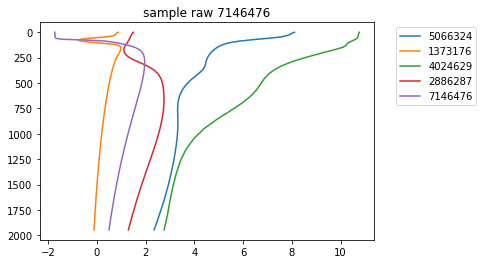

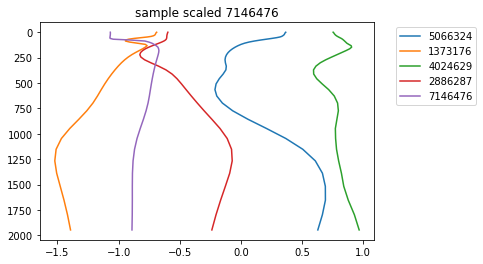

In [21]:
#Scaled temperature profile plotting cell
solo = False #Set to true for seperate plots, false for combined plots.
for i in range(5):
    x = np.random.randint(len(sampleMetaDF))
    tempPointPlot(sampleData[x], x, "sample raw "+str(x), solo*2*i)
    tempPointPlot(sampleDataScaled[x], x, "sample scaled "+str(x), solo*2*i+1)
plt.show()

<br>

### Principle Component Analysis
This process is performed to reduce the number of dimensions of the the data, as well as to improve overall model
performance.

In [22]:
#PCA importing cell
importName = modelName + "_PCA.pkl"
pca = pk.load(open(importName, "rb"))
totalVarianceExplained = np.sum(pca.explained_variance_ratio_)
print("PCA loaded into pca. Total variance explained by PCA for "+str(pca.n_components)+" is "+str(totalVarianceExplained)+".")

PCA loaded into pca. Total variance explained by PCA for 3 is 0.99104792822321.


In [23]:
#PCA transform cell
sampleDataScaledPCA = pca.transform(sampleDataScaled) #converting input data into PCA representation
print("Data passed through PCA to sampleDataPCA.")

Data passed through PCA to sampleDataPCA.


<br>

### Model import/BIC score calculation
The previously generated model is imported.

In [24]:
#Model import and BIC + Component Calculation Cell
bestGMModel = loadModel(modelName) #Loading model
bicMin = bestGMModel.bic(sampleDataScaledPCA) #BIC score calculation
bicComponentMin = bestGMModel.n_components #Identifying number of components in model (2 for this notebook)

print("Model "+modelName+" loaded. The bicScore was "+str(np.round(bicMin, 2))+" for "+str(bicComponentMin)+".")
print("Imported model "+modelName+" in use. No calculations necessary.")
print("Imported model "+modelName+" in use. Model BIC score for training data: "+str(bicMin)+".")

Model GMM_UK_2Class_R1 loaded. The bicScore was 85708603.96 for 2.
Imported model GMM_UK_2Class_R1 in use. No calculations necessary.
Imported model GMM_UK_2Class_R1 in use. Model BIC score for training data: 85708603.95785555.


<br>

### Assigning class labels to each profile using the best GMM
Implementation of classification.

In [25]:
#Classification and classification probability cell
labels = bestGMModel.predict(sampleDataScaledPCA) #Assignment of class labels from best GMM
posteriorProbs = bestGMModel.predict_proba(sampleDataScaledPCA) #Probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1) #Evaluating assigned class probability
classUncertainty = 2 - 2*maxPosteriorProbs #I factor calculation for 2 class system (reduces second max lookup)

In [26]:
#Initial class labels to sampleDF table cell
try: #Removing label, maxposteriorprob and classUncertainty columns from sampleDF
    sampleDF = sampleDF.drop(columns=["label", "max posterior prob", "classUncertainty"]) #removes any previous labels or probabilities
except:
    pass

#Adding label, maxposteriorprob and classUncertainty columns to sampleDF
sampleDF.insert(3, "label", labels, True)
sampleDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
sampleDF.insert(5, "classUncertainty", classUncertainty, True)
print("Labels identified for model ("+str(bicComponentMin)+" components) and added to sampleDF with associated probability.")

Labels identified for model (2 components) and added to sampleDF with associated probability.


<br>

### Calculating class means for sorting

In [27]:
#Class Mean Calculation Cell
sampleDFGrouped = sampleDF.groupby("label") #group profiles according to label
sampleDFMeans = sampleDFGrouped.mean() #calculate mean of all profiles in each class
print("Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).")

Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).


<br>

### Sorting the labels based on mean class temperatures

In [28]:
#Sorted Dictionary creation cell
surfaceMeans = sampleDFMeans[surfaceLev].to_numpy() #Takes first temperature data column
surfaceMeansOrder = np.argsort(surfaceMeans)
di = dict(zip(surfaceMeansOrder, range(0, bicComponentMin)))
print("Surface temperature means taken and sorted. Label dictionary created and stored in di.")

Surface temperature means taken and sorted. Label dictionary created and stored in di.


In [29]:
#Sorted label column to tables cell
try: #Removing labelSorted column from tables
    sampleMetaDF = sampleMetaDF.drop(columns = "labelSorted")
except:
    pass
try:
    sampleDF = sampleDF.drop(columns = "labelSorted")
except:
    pass

#Adding sorted label information to sampleMetaDF and sampleDF
sampleMetaDF.insert(3, "labelSorted", sampleDF["label"].map(di))
sampleDF.insert(5, "labelSorted", sampleDF["label"].map(di))
print("Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.")

Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.


In [30]:
#Probability data to sampleMeta table cell
try:
    sampleMetaDF = sampleMetaDF.drop(columns = ["max posterior prob", "classUncertainty"])
except:
    pass

sampleMetaDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
sampleMetaDF.insert(5, "classUncertainty", classUncertainty, True)

sampleMetaDF.head()

,lat,lon,time,labelSorted,max posterior prob,classUncertainty
0,-66.111519,73.5,1980-01-01,0,1.0,8.479114e-09
1,-65.703316,73.5,1980-01-01,0,1.0,1.119201e-09
2,-65.288567,73.5,1980-01-01,0,1.0,2.977263e-10
3,-64.867195,73.5,1980-01-01,0,1.0,1.496128e-10
4,-64.439102,73.5,1980-01-01,0,1.0,1.263656e-10


<br>

### Use pandas to calculate the properties of the profiles by sorted label

In [ ]:
#Class temperature means and stds cell
sampleDFSortGrouped = sampleDF.groupby("labelSorted")
sampleDFSortMeans = sampleDFSortGrouped.mean()
sampleDFSortStds = sampleDFSortGrouped.std()
profileCount = sampleDFSortGrouped[sampleDF.columns[0]].count().to_numpy()
print("sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).")
print("Number of samples in each group calculated and stored in profileCount.")

<br>

### Confirmation of sorting
The means printed below should be ordered, going from coldest to warmest.

In [ ]:
#Temperature display cell
print(sampleDFSortMeans[sampleDataDF.columns[0]])

<br>

### Plotting the means and standard deviations of the classes by profile

In [ ]:
#Plotting mean and std profiles cell
tempGroupProfile(sampleDFSortMeans, sampleDFSortStds, 1)
plt.show()

<br>

### Plotting location and cluster

In [ ]:
#surfaceTempPlot(sampleDF, 1)
plt.show()

In [ ]:
#locationPlotGroupDFLab(sampleDF, "Location plot of grouping", (25,25), 1)
plt.show()

In [ ]:
#locationPlotGroupDFMonthly(sampleDF, "Monthly summaries for training data set", 1)
print("Classifications, grouped by month.")
plt.show()

In [ ]:
#locationPlotUncertaintyDFMonthly(sampleDF, "Monthly uncertainty", 1)
print("Uncertainty in classifications, grouped by month.")
plt.show()

<br>

### Exporting Meta Data

In [ ]:
sampleMetaDF.head()

In [ ]:
#Meta data export cell
exportName = modelName + "_Meta_Full"
sampleMetaDF.to_csv(exportName) #Exporting meta data
print("Meta data and mask exported to "+ exportName +".")

In [ ]:
#Meta data reload cell
importName = modelName + "_Meta_Full"
sampleMetaReload = pd.read_csv(importName)
print("Meta data reloaded from "+ importName +". "+str(len(sampleMetaReload))+" data points.")
sampleMetaReload.head()

### End of Notebook